# Predict the Sun Hours using Naive Bayes Classifier and KNN Classifier

## import modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preprocessing

We use the same data resource as in L5, i.e., [Daily Weather Observations of Sydney, New South Wales between Aug 2015 and Aug 2016](http://www.bom.gov.au/climate/dwo/IDCJDW0210.shtml).

We will handle the missing values, and category Sun_hours into three levels: High(>10), Med(>5 and <=10), and Low(<=5) as we did in L5.

### Column Meanings
| Heading         | Meaning                                                  | Units               |
|-----------------|----------------------------------------------------------|---------------------|
| Day             | Day of the week                                          | first two letters   |
| Temps_min       | Minimum temperature in the 24 hours to 9am.              | degrees Celsius     |
| Temps_max       | Maximum temperature in the 24 hours from 9am.            | degrees Celsius     |
| Rain            | Precipitation (rainfall) in the 24 hours to 9am.         | millimetres         |
| Evap            | Class A pan evaporation in the 24 hours to 9am           | millimetres         |
| Sun_hours       | Bright sunshine in the 24 hours to midnight              | hours               |
| Max_wind_dir    | Direction of strongest gust in the 24 hours to midnight  | 16 compass points   |
| Max_wind_spd    | Speed of strongest wind gust in the 24 hours to midnight | kilometres per hour |
| Max_wind_time   | Time of strongest wind gust                              | local time hh:mm    |
| Temp_at_9am     | Temperature at 9 am                                      | degrees Celsius     |
| RH_at_9am       | Relative humidity at 9 am                                | percent             |
| CLD_at_9am      | Fraction of sky obscured by cloud at 9 am                | eighths             |
| Wind_dir_at_9am | Wind direction averaged over 10 minutes prior to 9 am    | compass points      |
| Wind_spd_at_9am | Wind speed averaged over 10 minutes prior to 9 am        | kilometres per hour |
| MSLP_at_9am     | Atmospheric pressure reduced to mean sea level at 9 am   | hectopascals        |
| Temp_at_3pm     | Temperature at 3 pm                                      | degrees Celsius     |
| RH_at_3pm       | Relative humidity at 3 pm                                | percent             |
| CLD_at_3pm      | Fraction of sky obscured by cloud at 3 pm                | eighths             |
| Wind_dir_at_3pm | Wind direction averaged over 10 minutes prior to 3 pm    | compass points      |
| Wind_spd_at_3pm | Wind speed averaged over 10 minutes prior to 3 pm        | kilometres per hour |
| MSLP_at_3pm     | Atmospheric pressure reduced to mean sea level at 3 pm   | hectopascals        |

In [2]:
data = pd.read_csv('./asset/Daily_Weather_Observations.csv', sep=',')
data_missing_sun_hours = data[pd.isnull(data['Sun_hours'])]
data = data[pd.notnull(data['Sun_hours'])]

labels = ['Low','Med','High']
data['Sun_level'] = pd.cut(data.Sun_hours, [-1,5,10,25], labels=labels)

data = data.dropna(subset = ['CLD_at_9am', 'Max_wind_dir', 'Max_wind_spd', 'Max_wind_dir'])
bitmap1 = data.Evap.notnull()
bitmap2 = bitmap1.shift(1)
bitmap2[0] = True
data = data[bitmap1 & bitmap2]

data['Temps_diff'] = data['Temps_max'] - data['Temps_min']

print(data.shape)

(362, 26)


We use *CLD_at_9am*, *CLD_at_3pm*, *RH_at_9am*, *RH_at_3pm*, and *Temps_diff* as features.

In [3]:
feature_list = ['CLD_at_9am', 'CLD_at_3pm', 'RH_at_9am', 'RH_at_3pm', 'Temps_diff']

We generate X and y based on the selected features and labels

In [4]:
X = data[feature_list]
X.tail()

,CLD_at_9am,CLD_at_3pm,RH_at_9am,RH_at_3pm,Temps_diff
391,7.0,7,57,50,10.0
392,1.0,1,57,45,12.5
393,1.0,2,50,36,12.1
394,7.0,7,57,38,11.2
395,7.0,6,71,62,9.2


In [5]:
y = data.Sun_level
y.tail()

391     Med
392    High
393    High
394     Med
395     Low
Name: Sun_level, dtype: category
Categories (3, object): [Low < Med < High]

## (Gaussian) Naive Bayes Classifier

In [6]:
gnb = GaussianNB() # Note that there is no parameter allowed in GaussianNB()
gnb.fit(X, y)
gnb.score(X, y)

0.73204419889502759

You can get the probability estimates for the input vector X.

In [7]:
gnb.predict_proba(X)

array([[  1.79281852e-02,   2.18950571e-03,   9.79882309e-01],
       [  9.08261588e-02,   9.89759965e-04,   9.08184081e-01],
       [  8.92937811e-01,   8.73826443e-13,   1.07062189e-01],
       ..., 
       [  9.02419655e-01,   1.84466699e-11,   9.75803449e-02],
       [  1.35234568e-03,   7.09322475e-02,   9.27715407e-01],
       [  3.73481033e-04,   7.76129501e-01,   2.23497018e-01]])

## KNN Classifier

Before classification, we need to normalize the data first.

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled.shape

(362, 5)

The following parameters affects the performance (accuracy) of the classifier
 * *n_neighbors*: Number of neighbors to use
 * *weights*: weight function of the points. Possible values are:
   * ‘uniform’ : uniform weights.
   * ‘distance’ : weight points by the inverse of their distance.
   * [callable] : a user-defined weight function.
 * *metric*: The distance metric to use. The default metric is minkowski.
 * *p*: Power parameter for the Minkowski metric (assume we use the default metric). Usual choices are:
   * p = 2: Euclidean Distance
   * p = 1: Manhattan Distance

In [9]:
neigh = KNeighborsClassifier(n_neighbors=3,weights='uniform',p=2)
neigh.fit(X_scaled, y)
neigh.score(X_scaled, y)

0.82320441988950277

## Cross Validation

We use K-fold cross validation to get a reliable estimate of how well a model performs on unseen data (i.e., the generalization error). This helps to (1) determine which model works well, or (2) how to set the values for the hyper parameters for a model. We will see an example of the latter usage in finding the best $k$ for kNN classifiers.  

In [10]:
n_folds = 10
kf = KFold(n=len(X), n_folds=n_folds, shuffle=True, random_state=42)

In [11]:
def test_Gaussian_NB(train_X, train_y, test_X, test_y, debug_flag = False):
    gnb = GaussianNB()
    gnb.fit(train_X, train_y)
    train_error = gnb.score(train_X, train_y)
    test_error = gnb.score(test_X, test_y)
    if debug_flag:
        print('=============')
        print('training error:\t{}'.format(train_error))
        print('testing error:\t{}'.format(test_error))
    return train_error, test_error

def test_KNN(train_X, train_y, test_X, test_y, n_neighbors=3, weights='uniform', p=2, debug_flag = False):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    neigh.fit(train_X, train_y)
    train_error = neigh.score(train_X, train_y)
    test_error = neigh.score(test_X, test_y)
    if debug_flag:
        print('=============')
        print('training error:\t{}'.format(train_error))
        print('testing error:\t{}'.format(test_error))
    return train_error, test_error

### CV on Naive Bayes Classifier

In [12]:
train_error_total = 0
test_error_total = 0
for train, test in kf:
    train_X = X.iloc[train]
    test_X = X.iloc[test]
    train_y = y.iloc[train]
    test_y = y.iloc[test]
    train_error, test_error = test_Gaussian_NB(train_X, train_y, test_X, test_y)
    train_error_total += train_error
    test_error_total += test_error

print('===================')
print('avg. training error (Gaussian NB):\t{}'.format(train_error_total/n_folds))
print('avg. testing error (Gaussian NB):\t{}'.format(test_error_total/n_folds))

avg. training error (Gaussian NB):	0.73756866446437
avg. testing error (Gaussian NB):	0.7318318318318319


### CV on KNN Classifier

In [13]:
def cv(n_neighbors=3,weights='uniform',p=2):
    train_error_total = 0
    test_error_total = 0
    for train, test in kf:
        train_X = X_scaled[train]
        test_X = X_scaled[test]
        train_y = y.iloc[train]
        test_y = y.iloc[test]
        train_error, test_error = test_KNN(train_X, train_y, test_X, test_y, n_neighbors, weights, p)
        train_error_total += train_error
        test_error_total += test_error
    return train_error_total/n_folds, test_error_total/n_folds
#     print('===================')
#     print('avg. training error (kNN):\t{}'.format(train_error_total/n_folds))
#     print('avg. testing error (kNN):\t{}'.format(test_error_total/n_folds))
#     print()

In [14]:
def cv_plot(weights='uniform',p=2):
    cv_res = []
    for i in range(1,50):
        train_error, test_error = cv(i, weights, p)
        cv_res.append([i, train_error, test_error])
    cv_res_arr = np.array(cv_res)
    plt.figure(figsize=(16,9)) 
    plt.title('Errors vs k for kNN classifiers')
    plot_train, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,1], label='training')
    plot_test, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,2], label='testing')
    plt.legend(handles=[plot_train, plot_test])
    plt.ylim((min(min(cv_res_arr[:,1]), min(cv_res_arr[:,2])) - 0.05, max(max(cv_res_arr[:,1]), max(cv_res_arr[:,2]))+0.05))

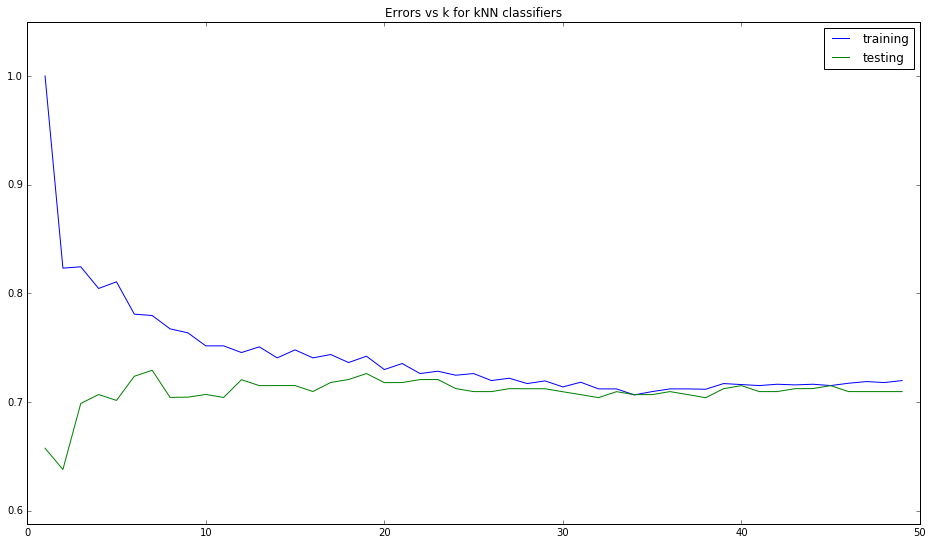

In [15]:
cv_plot('uniform',2)

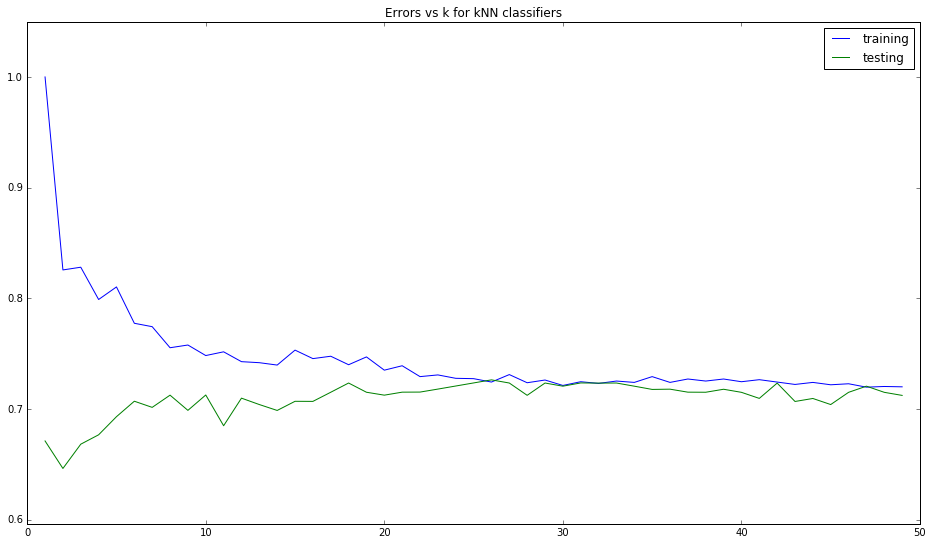

In [16]:
cv_plot('uniform',1)

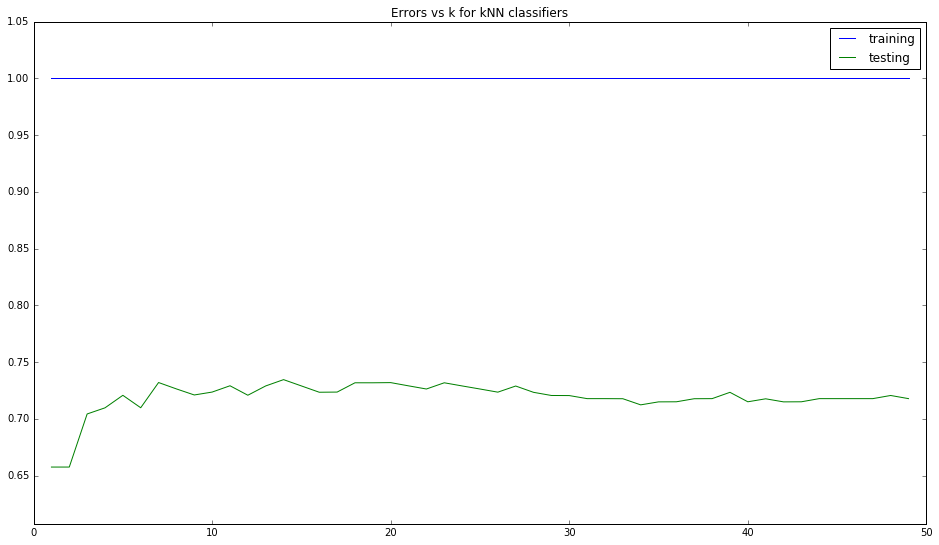

In [17]:
cv_plot('distance',2)

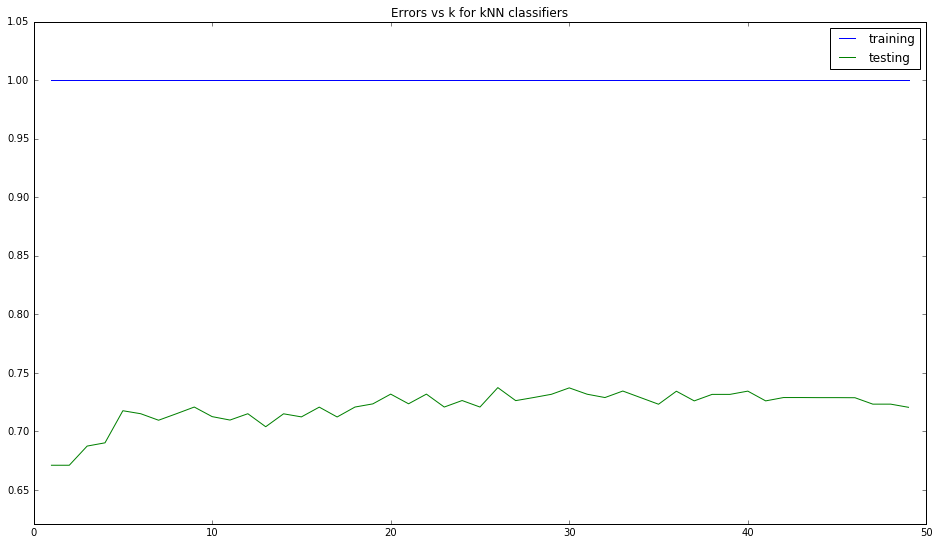

In [18]:
cv_plot('distance',1)

According to the above results, we decide to use *k=27* and *uniform* weight with *p=1*. Then we use these parameters to train a classifier over all the data (i.e., X_scaled)

In [19]:
neigh = KNeighborsClassifier(n_neighbors=27,weights='uniform',p=1)
neigh.fit(X_scaled, y)
neigh.score(X_scaled, y)

0.72928176795580113

We also need to normalize data, but be aware that we need to make sure that testing data and training data are normalized in the same way (e.g., use ```min_max_scaler.transform()```)

In [20]:
data_missing_sun_hours['Temps_diff'] = data_missing_sun_hours['Temps_max'] - data_missing_sun_hours['Temps_min']
test_data = data_missing_sun_hours[feature_list]
test_data_scaled = min_max_scaler.transform(test_data)
test_data

,CLD_at_9am,CLD_at_3pm,RH_at_9am,RH_at_3pm,Temps_diff
116,1.0,0,62,44,15.4
126,1.0,1,56,52,9.4
141,1.0,1,61,52,10.4
166,1.0,7,50,43,16.5
334,1.0,7,78,33,11.1
335,7.0,1,58,33,9.0
369,6.0,7,90,60,7.3


Now let's predict the sun_level using both KNN classifier and Naive Bayes classifier.

In [21]:
data_missing_sun_hours['Sun_level_pred_knn'] = neigh.predict(test_data_scaled)
data_missing_sun_hours

,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,Wind_spd_at_9am,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm,Temps_diff,Sun_level_pred_knn
116,2015,11,25,We,17.3,32.7,0.0,9.0,NaN,NNE,...,9,1013.1,28.7,44,0,NNE,24,1007.4,15.4,High
126,2015,12,5,Sa,15.5,24.9,0.0,8.0,NaN,NE,...,7,1022.6,24.1,52,1,NE,20,1018.9,9.4,High
141,2015,12,20,Su,19.9,30.3,0.0,13.0,NaN,NE,...,11,1013.4,28.5,52,1,NNE,31,1008.7,10.4,High
166,2016,1,14,Th,22.7,39.2,0.0,8.4,NaN,S,...,6,1011.7,32.4,43,7,ENE,15,1008.1,16.5,Med
334,2016,6,30,Th,5.4,16.5,0.0,1.8,NaN,NW,...,11,1021.2,14.5,33,7,NNW,24,1015.1,11.1,Med
335,2016,7,1,Fr,7.7,16.7,0.0,4.0,NaN,NW,...,13,1015.7,16.4,33,1,WSW,20,1016.2,9.0,High
369,2016,8,4,Th,10.8,18.1,61.0,9.4,NaN,SE,...,15,1024.3,15.5,60,7,SSW,19,1025.1,7.3,Low


In [22]:
data_missing_sun_hours['Sun_level_pred_nb'] = gnb.predict(test_data)
data_missing_sun_hours

,Year,Month,Date,Day,Temps_min,Temps_max,Rain,Evap,Sun_hours,Max_wind_dir,...,MSLP_at_9am,Temp_at_3pm,RH_at_3pm,CLD_at_3pm,Wind_dir_at_3pm,Wind_spd_at_3pm,MSLP_at_3pm,Temps_diff,Sun_level_pred_knn,Sun_level_pred_nb
116,2015,11,25,We,17.3,32.7,0.0,9.0,NaN,NNE,...,1013.1,28.7,44,0,NNE,24,1007.4,15.4,High,High
126,2015,12,5,Sa,15.5,24.9,0.0,8.0,NaN,NE,...,1022.6,24.1,52,1,NE,20,1018.9,9.4,High,High
141,2015,12,20,Su,19.9,30.3,0.0,13.0,NaN,NE,...,1013.4,28.5,52,1,NNE,31,1008.7,10.4,High,High
166,2016,1,14,Th,22.7,39.2,0.0,8.4,NaN,S,...,1011.7,32.4,43,7,ENE,15,1008.1,16.5,Med,Med
334,2016,6,30,Th,5.4,16.5,0.0,1.8,NaN,NW,...,1021.2,14.5,33,7,NNW,24,1015.1,11.1,Med,Med
335,2016,7,1,Fr,7.7,16.7,0.0,4.0,NaN,NW,...,1015.7,16.4,33,1,WSW,20,1016.2,9.0,High,Med
369,2016,8,4,Th,10.8,18.1,61.0,9.4,NaN,SE,...,1024.3,15.5,60,7,SSW,19,1025.1,7.3,Low,Low
